
[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
Test Cases: 100
Misses: 0
Accuracy: 100.0%


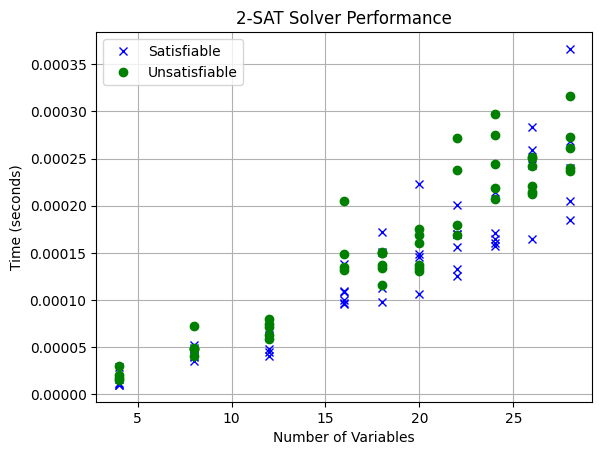

In [9]:
# install libraries
!pip install matplotlib
!pip install python-sat
import csv
import time
import matplotlib.pyplot as plt
from pysat.formula import CNF
from pysat.solvers import Solver


# function for pure literal elimination
def literal_elimination(clauses, assignment):

    literals = [literal for clause in clauses for literal in clause]

    #find pure literals
    p_literals = set(literal for literal in literals if -literal not in literals)


    # assign value to pure literals
    for literal in p_literals:
        assignment[abs(literal)] = (literal > 0)
        clauses = simplify_clauses(clauses, literal)

    # return updates
    return clauses, assignment

# use unit propagation to assign values to unit clauses
def unit_propagation(clauses, assignment):
    while True:

        # look for unit clauses
        unit_c = [clause for clause in clauses if len(clause) == 1]

        # break if no unit clauses
        if not unit_c:
            break


        # assign value based on unit literal and simplified clauses
        for unit in unit_c:

            literal = unit[0]
            # assign the literal a random value
            assignment[abs(literal)] = (literal > 0)
            # simplify clauses
            clauses = simplify_clauses(clauses, literal)

    # return changes
    return clauses, assignment


# simplify clauses when possible
def simplify_clauses(clauses, literal):

    new_clauses = []

    for clause in clauses:
        if literal in clause:
            continue

        new_clause = [lit for lit in clause if lit != - literal]
        new_clauses.append(new_clause)

    return new_clauses

# dpll algorithm
def dpll(clauses, assignment):
    # call unit prop and pure literal elimination
    clauses, assignment = unit_propagation(clauses, assignment)
    clauses, assignment = literal_elimination(clauses, assignment)


    # check is clauses are satisfied
    if not clauses:
        return True, assignment
    

    # check for empty clauses
    if any(len(clause) == 0 for clause in clauses):
        return False, assignment

    # recursivly try new assignments 
    a = abs(clauses[0][0])
    for i in [True, False]:
        assignment[a] = i
        s = simplify_clauses(clauses, a if i else -a)
        result, exec_val = dpll(s, assignment.copy())
        if result:
            return True, exec_val

    return False, assignment

# calls dpll
def two_sat_solver(clauses, variables):
    #initializes empty assignments
    assignment = {i: None for i in range(1, variables + 1)}
    result, exec_val = dpll(clauses, assignment)

    return result, exec_val

# plot function
def plot_results(sv, st, uv, ut):
    plt.figure()

    plt.plot(sv, st, marker='x', linestyle='None', color='b', label='Satisfiable')

    plt.plot(uv, ut, marker='o', linestyle='None', color='g', label='Unsatisfiable')

    plt.title('2-SAT Solver Performance')
    plt.xlabel('Number of Variables')
    plt.ylabel('Time (seconds)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Main function
def main():
    # variables for variables, clauses, and number of test cases
    v = 0
    cur_c = []
    test_case_count = 0

    # separate lists for satisfiable and unsatisfiable
    st = []
    ut = []
    sv = []
    uv = []
    results = []
  
    # track how many we got wrong
    misses = 0

    # open csv file
    with open('2SAT.cnf.csv') as csvfile:
      
        # solve every test case
        for line in csvfile:

            #ignore comments
            if line.startswith('c'):
                continue

                #solve when we have reached the end of our sat problem
            elif line.startswith('p'):
                if cur_c:
                
                #solve, measure time, and check accuracy
                    start_time = time.time()
                    # get result
                    result, assignment = two_sat_solver(cur_c, v)
                    end_time = time.time()

                    elapsed_time = end_time - start_time
                    # track number of test cases
                    test_case_count += 1
                    # use python library to check accuracy
                    if result:
                        with Solver(name='g3') as solver:
                          is_valid = solver.solve(assumptions=assignment)
                          if not is_valid:
                            misses += 1
                        st.append(elapsed_time)
                        sv.append(v)
                        results.append([test_case_count, v, elapsed_time, "Satisfiable", "Valid"if  is_valid else "Invalid"])
                    else:
                        is_satisfiable = solver.solve()
                        if is_satisfiable:
                          misses += 1
                        ut.append(elapsed_time)
                        uv.append(v)
                        results.append([test_case_count, v, elapsed_time, "Unsatisfiable", "Valid" if is_satisfiable else "Invalid"])

                    cur_c = []

                seg = line.replace(",", " ").split()
                if len(seg) == 4 and seg[0] == 'p' and seg[1] == 'cnf':
                    v = int(seg[2])

          
            else:
                try:
                    clause = [int(literal) for literal in line.replace(",", " ").split() if int(literal) != 0]
                    cur_c.append(clause)
                except ValueError:
                    continue


        # final test case (same logic as loop)
        if cur_c:
            start_time = time.time()
            result, assignment = two_sat_solver(cur_c, v)
            end_time = time.time()

            elapsed_time = end_time - start_time
            test_case_count += 1

            if result:
                with Solver(name='g3') as solver:
                  is_valid = solver.solve(assumptions=assignment)
                  if not is_valid:
                    misses += 1
                st.append(elapsed_time)
                sv.append(v)
                results.append([test_case_count, v, elapsed_time, "Satisfiable", "Valid"if  is_valid else "Invalid"])
            else:
                is_satisfiable = solver.solve()
                if is_satisfiable:
                    misses += 1
                ut.append(elapsed_time)
                uv.append(v)
                results.append([test_case_count, v, elapsed_time, "Unsatisfiable", "Valid" if is_satisfiable else "Invalid"])       

            # write all results to a csv file
            with open('results.csv', mode='w', newline='') as file:
                writer = csv.writer(file)
                writer.writerow(['Test Case', 'V', 'Elapsed Time', 'Satisfiability', 'Validity'])
                writer.writerows(results)     
    
    # print accuracy     
    print(f"Test Cases: {test_case_count}")
    print(f"Misses: {misses}")
    print(f"Accuracy: {(test_case_count- misses) * 100/test_case_count}%")
    plot_results(sv, st, uv, ut)


#call main function
main()
